In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from sklearn import metrics
import math

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

from pipeline import evaluate, plot_and_eval

# Goals

#### Analyze Fitbit data to
 - Project the two weeks of missing data
 - Determine what extra data label was included
 - Create a profile of the person who possesses the Fitbit

# Takeaways

# Plan

# Acquire

- Read in master .csv file, cleaned from original 8 .csv files.

- Read in 225 rows and 9 columns.

- Read in file with 'Date' column as DatetimeIndex.

In [2]:
df = pd.read_csv('fitbit_master.csv', index_col='Date', parse_dates=True)

In [3]:
df.shape

(225, 9)

# Prepare

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           225 non-null int64
Steps                     225 non-null int64
Distance                  225 non-null float64
Floors                    225 non-null int64
Minutes Sedentary         225 non-null int64
Minutes Lightly Active    225 non-null int64
Minutes Fairly Active     225 non-null int64
Minutes Very Active       225 non-null int64
Activity Calories         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


## Resample by Day by Sum

In [5]:
df = df.resample('D').sum()

## Check Latest Date

- 2018-12-06

- projection will be two weeks out from this date

In [6]:
df.index.max()

Timestamp('2018-12-06 00:00:00')

In [7]:
df.index.min()

Timestamp('2018-04-26 00:00:00')

## Rename Columns

In [8]:
df.columns

Index(['Calories Burned', 'Steps', 'Distance', 'Floors', 'Minutes Sedentary',
       'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories'],
      dtype='object')

In [9]:
df = df.rename(columns={'Calories Burned': 'calories_burned', 'Steps': 'steps', 'Distance': 'distance', 
                  'Floors': 'floors', 'Minutes Sedentary': 'sedentary_mins', 'Minutes Lightly Active': 'lightly_active_mins',
                  'Minutes Fairly Active': 'fairly_active_mins', 'Minutes Very Active': 'very_active_mins', 
                'Activity Calories': 'activity_calories'})

In [10]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124
2018-04-29,2851,1639,0.8,0,891,122,0,0,602
2018-04-30,2825,1323,0.6,0,880,104,0,0,540


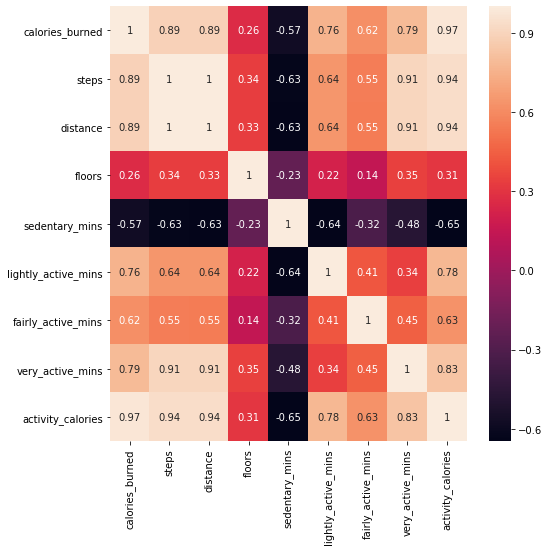

In [11]:
plt.figure(figsize = (8,8))
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

## Add column with total of all activity

In [12]:
df['active_total'] = df.lightly_active_mins + df.fairly_active_mins + df.very_active_mins

## Add column with ratio of distance to steps (stride)

In [13]:
df['stride'] = df.distance/ df.steps

## Add a Month Column

In [14]:
df['month'] = df.index.month

## Add a Day of the Week Column

In [15]:
df['weekday'] = df.index.strftime('%w %a')

In [16]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,month,weekday
Date,,,,,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566,93,0.000478,4,4 Thu
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752,282,0.000471,4,5 Fri
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124,188,0.000483,4,6 Sat
2018-04-29,2851,1639,0.8,0,891,122,0,0,602,122,0.000488,4,0 Sun
2018-04-30,2825,1323,0.6,0,880,104,0,0,540,104,0.000454,4,1 Mon


# Explore

- Begin stage with 225 rows and 13 columns

- 33 Thursdays, 32 each Friday through Wednesday

    - We will drop the first row which is a Thursday to keep weekday count equal.

In [17]:
df.shape

(225, 13)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Freq: D
Data columns (total 13 columns):
calories_burned        225 non-null int64
steps                  225 non-null int64
distance               225 non-null float64
floors                 225 non-null int64
sedentary_mins         225 non-null int64
lightly_active_mins    225 non-null int64
fairly_active_mins     225 non-null int64
very_active_mins       225 non-null int64
activity_calories      225 non-null int64
active_total           225 non-null int64
stride                 213 non-null float64
month                  225 non-null int64
weekday                225 non-null object
dtypes: float64(2), int64(10), object(1)
memory usage: 24.6+ KB


In [19]:
df.describe()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,month
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,213.000000,225.000000
mean,3401.911111,8536.186667,4.052000,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667,237.026667,0.000471,8.008889
std,632.426578,5255.746608,2.507472,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790,103.121761,0.000048,2.144326
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,3069.000000,4714.000000,2.200000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000,187.000000,0.000469,6.000000
50%,3385.000000,7806.000000,3.700000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000,253.000000,0.000472,8.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000,299.000000,0.000477,10.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000,505.000000,0.000581,12.000000


## Equalize Weekdays

- Drop the first row leaving us with 224 rows, 13 columns

In [20]:
# retrieve a weekday count, drop the first Thursday '2018-04-26'

df['weekday'].value_counts()

4 Thu    33
1 Mon    32
2 Tue    32
0 Sun    32
6 Sat    32
5 Fri    32
3 Wed    32
Name: weekday, dtype: int64

In [21]:
# drop the first row, an extra Thursday

df = df[df.index != "2018-04-26"]

## Fill Stride Column NaNs or infs with 0

In [22]:
df['stride'] = df.stride.fillna(0)

In [23]:
df = df.replace([np.inf, -np.inf], 0)

In [24]:
df.isnull().sum()

calories_burned        0
steps                  0
distance               0
floors                 0
sedentary_mins         0
lightly_active_mins    0
fairly_active_mins     0
very_active_mins       0
activity_calories      0
active_total           0
stride                 0
month                  0
weekday                0
dtype: int64

In [25]:
(df == 0).astype(int).sum().sort_values(ascending = False)

very_active_mins       50
fairly_active_mins     45
floors                 31
stride                 14
distance               14
steps                  12
active_total            9
activity_calories       9
lightly_active_mins     9
weekday                 0
month                   0
sedentary_mins          0
calories_burned         0
dtype: int64

## Look at Days with 0 Steps

- There are 0 values for steps in the following dates/date ranges

    - 6/6 - 6/7
    - 6/11
    - 6/26 - 6/30
    - 7/3 - 7/6
    
- We will look for trends before and after the breaks to decide how to handle these rows.

In [26]:
df[df['steps'] == 0]

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,month,weekday
Date,,,,,,,,,,,,,
2018-06-06,2145,0,0.0,0,1440,0,0,0,0,0,0.0,6,3 Wed
2018-06-07,2146,0,0.0,0,1440,0,0,0,0,0,0.0,6,4 Thu
2018-06-11,2146,0,0.0,0,1440,0,0,0,0,0,0.0,6,1 Mon
2018-06-26,2144,0,0.0,0,1440,0,0,0,0,0,0.0,6,2 Tue
2018-06-27,2145,0,0.0,0,1440,0,0,0,0,0,0.0,6,3 Wed
2018-06-28,2145,0,0.0,0,1440,0,0,0,0,0,0.0,6,4 Thu
2018-06-29,2180,0,0.0,0,1437,3,0,0,39,3,0.0,6,5 Fri
2018-06-30,2145,0,0.0,0,1440,0,0,0,0,0,0.0,6,6 Sat
2018-07-03,2144,0,0.0,0,1440,0,0,0,0,0,0.0,7,2 Tue


## Calculate Mean Values by Weekdays

In [27]:
# Means for Mondays

df[df['weekday'] == '1 Mon'].median()

calories_burned        3196.500000
steps                  6187.000000
distance                  2.900000
floors                    6.000000
sedentary_mins          761.000000
lightly_active_mins     196.500000
fairly_active_mins        8.000000
very_active_mins         12.000000
activity_calories      1268.500000
active_total            220.000000
stride                    0.000471
month                     8.000000
dtype: float64

In [28]:
# Means for Tuesdays

df[df['weekday'] == '2 Tue'].median()

calories_burned        3388.500000
steps                  7298.000000
distance                  3.450000
floors                    6.000000
sedentary_mins          774.000000
lightly_active_mins     196.000000
fairly_active_mins        9.000000
very_active_mins         11.500000
activity_calories      1401.500000
active_total            240.500000
stride                    0.000471
month                     8.000000
dtype: float64

In [29]:
# Means for Wednesdays

df[df['weekday'] == '3 Wed'].median()

calories_burned        3329.500000
steps                  7600.000000
distance                  3.600000
floors                    6.500000
sedentary_mins          770.500000
lightly_active_mins     200.000000
fairly_active_mins        7.500000
very_active_mins         13.500000
activity_calories      1368.000000
active_total            236.500000
stride                    0.000471
month                     8.000000
dtype: float64

In [30]:
# Means for Thursdays

df[df['weekday'] == '4 Thu'].median()

calories_burned        3469.000000
steps                  9556.500000
distance                  4.500000
floors                    7.000000
sedentary_mins          759.000000
lightly_active_mins     206.500000
fairly_active_mins       10.000000
very_active_mins         16.500000
activity_calories      1673.500000
active_total            269.000000
stride                    0.000473
month                     8.000000
dtype: float64

In [31]:
# Means for Wednesdays

df[df['weekday'] == '5 Fri'].median()

calories_burned        3470.000000
steps                  8872.000000
distance                  4.200000
floors                    7.000000
sedentary_mins          759.500000
lightly_active_mins     203.000000
fairly_active_mins       11.500000
very_active_mins         14.000000
activity_calories      1623.000000
active_total            274.000000
stride                    0.000471
month                     8.000000
dtype: float64

In [32]:
# Means for Wednesdays

df[df['weekday'] == '6 Sat'].median()

calories_burned        3421.500000
steps                  8792.500000
distance                  4.150000
floors                    7.000000
sedentary_mins          688.000000
lightly_active_mins     205.000000
fairly_active_mins       19.500000
very_active_mins         20.500000
activity_calories      1597.500000
active_total            263.000000
stride                    0.000474
month                     8.000000
dtype: float64

## Plots

### Calories Burned by Month

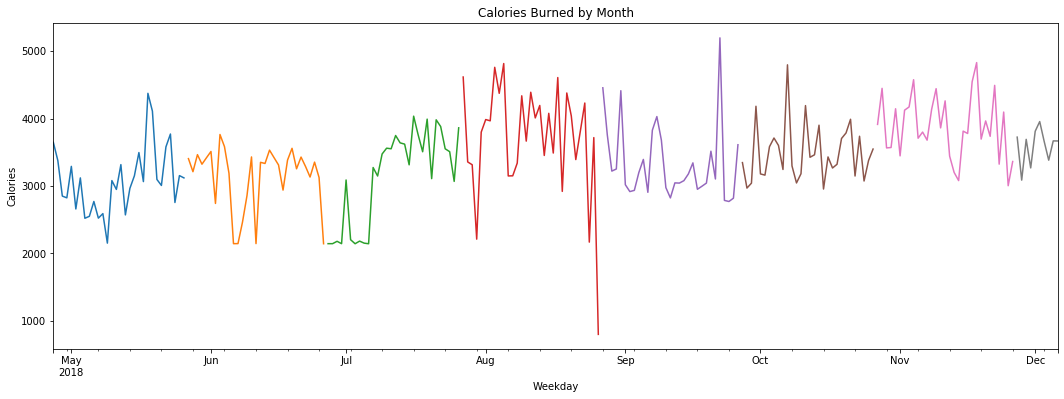

In [33]:
df['calories_burned']['2018-04-27':'2018-05-26'].plot(figsize= (18,6))
df['calories_burned']['2018-05-27':'2018-06-26'].plot()
df['calories_burned']['2018-06-27':'2018-07-26'].plot()
df['calories_burned']['2018-07-27':'2018-08-26'].plot()
df['calories_burned']['2018-08-27':'2018-09-26'].plot()
df['calories_burned']['2018-09-27':'2018-10-26'].plot()
df['calories_burned']['2018-10-27':'2018-11-26'].plot()
df['calories_burned']['2018-11-27':'2018-12-06'].plot()

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Calories Burned by Month')
plt.show()

### Average Calories Burned by Weekday

- Most calores burned on Saturdays and Sundays

In [34]:
df.groupby(['weekday']).calories_burned.mean()

weekday
0 Sun    3551.46875
1 Mon    3242.75000
2 Tue    3304.09375
3 Wed    3270.46875
4 Thu    3450.65625
5 Fri    3464.71875
6 Sat    3553.18750
Name: calories_burned, dtype: float64

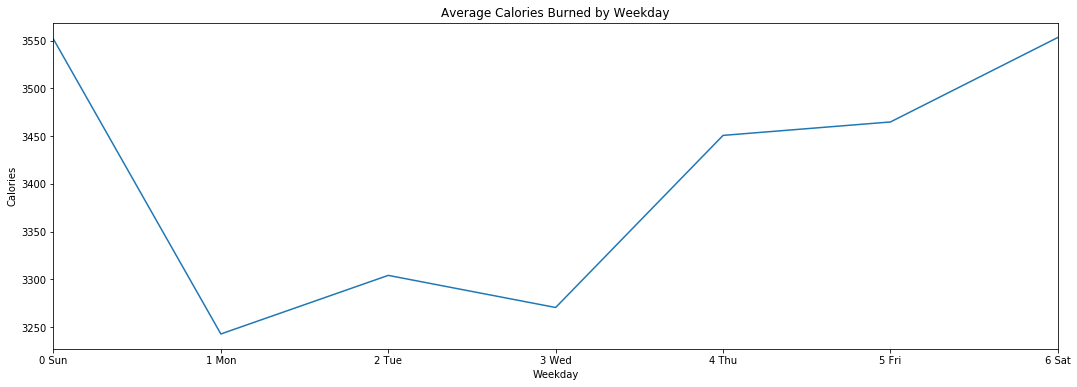

In [35]:
df.groupby(['weekday'])['calories_burned'].mean().plot(figsize = (18,6))

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Average Calories Burned by Weekday')
plt.show()

### Number of Steps by Day

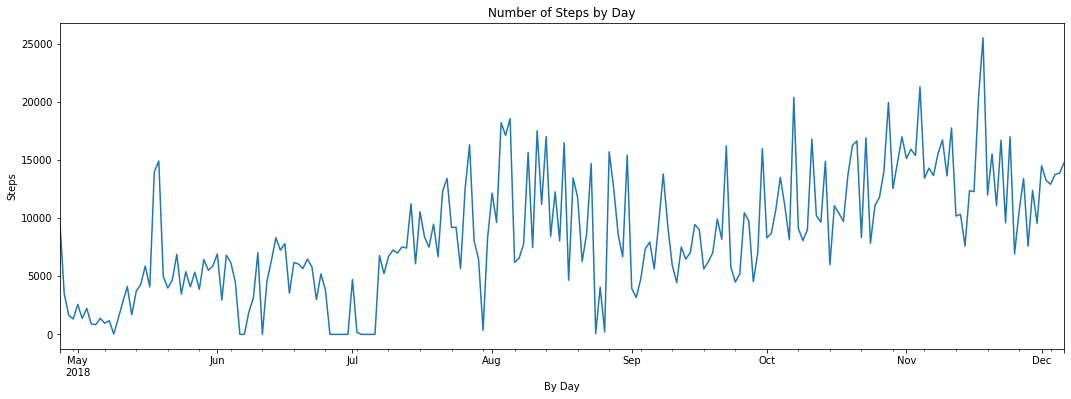

In [36]:
df['steps'].plot(figsize=(18,6))

plt.xlabel('By Day')
plt.ylabel('Steps')
plt.title('Number of Steps by Day')
plt.show()

## Sedentary Mins Vs. Active Mins

<Figure size 864x864 with 0 Axes>

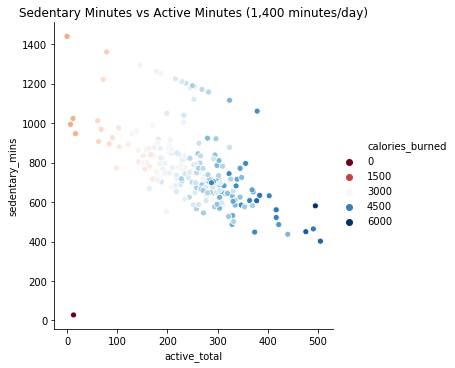

In [37]:
plt.figure(figsize = (12,12))
sns.relplot(x='active_total', y='sedentary_mins', data=df, alpha = 1, hue = 'calories_burned', palette = 'RdBu')
plt.title('Sedentary Minutes vs Active Minutes (1,400 minutes/day)')
plt.show()

## Drop Columns - Month, Weekday, and Floors for Modeling

In [38]:
df.columns

Index(['calories_burned', 'steps', 'distance', 'floors', 'sedentary_mins',
       'lightly_active_mins', 'fairly_active_mins', 'very_active_mins',
       'activity_calories', 'active_total', 'stride', 'month', 'weekday'],
      dtype='object')

In [39]:
df.drop(columns=['month', 'weekday', 'floors'], inplace=True)

### Takeaways:  Explore

- 

# Impute Simple Moving Averages (SMA)

- Create rm_steps and rm_distance columns using SMA that contain the original values for values and imputed values of the median where there are NaNs.

- This method can be skewed by more extreme historical values.

- Use a lambda function to convert values of 0 in the steps column to Nans.

- Decide on the best way to handle the missing step values in the data before going on to model using same methods to predict future values.

## Impute Median Values for Steps and Create Column rm_steps

In [40]:
df.steps = df.steps.apply(lambda x: np.nan if x == 0 else x)

In [41]:
df = df.assign(RollingMedian=df.steps.fillna(df.steps.rolling(14,min_periods=1,).median()))

In [42]:
df = df.rename(columns = {'RollingMedian' : 'rm_steps'})

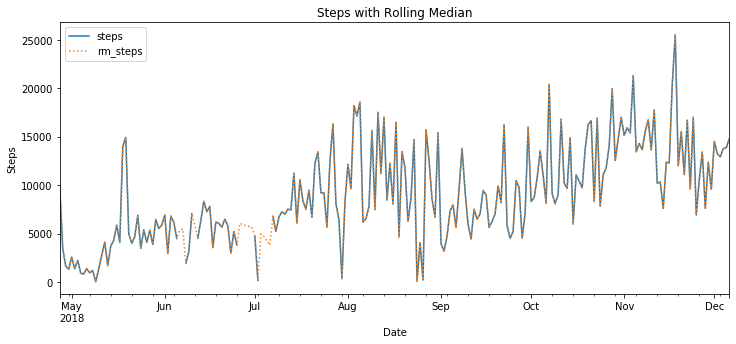

In [43]:
df['steps'].plot(figsize=(12,5))
df['rm_steps'].plot(style=':')

plt.title('Steps with Rolling Median')
plt.ylabel('Steps')
plt.legend()
plt.show()

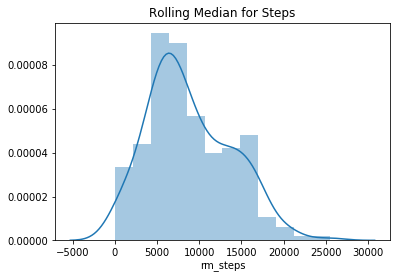

In [44]:
sns.distplot(df.rm_steps)

plt.title('Rolling Median for Steps')
plt.show()

In [45]:
df.head()

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,rm_steps
Date,,,,,,,,,,,
2018-04-27,3649,9971.0,4.7,1158,219,46,17,1752,282,0.000471,9971.0
2018-04-28,3379,3521.0,1.7,702,155,22,11,1124,188,0.000483,3521.0
2018-04-29,2851,1639.0,0.8,891,122,0,0,602,122,0.000488,1639.0
2018-04-30,2825,1323.0,0.6,880,104,0,0,540,104,0.000454,1323.0
2018-05-01,3292,2581.0,1.2,919,167,13,2,1068,182,0.000465,2581.0


## Impute Median Values for Distance and Create Column rm_distance

In [46]:
df.distance = df.distance.apply(lambda x: np.nan if x == 0 else x)

In [47]:
df.head()

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,rm_steps
Date,,,,,,,,,,,
2018-04-27,3649,9971.0,4.7,1158,219,46,17,1752,282,0.000471,9971.0
2018-04-28,3379,3521.0,1.7,702,155,22,11,1124,188,0.000483,3521.0
2018-04-29,2851,1639.0,0.8,891,122,0,0,602,122,0.000488,1639.0
2018-04-30,2825,1323.0,0.6,880,104,0,0,540,104,0.000454,1323.0
2018-05-01,3292,2581.0,1.2,919,167,13,2,1068,182,0.000465,2581.0


In [48]:
df = df.assign(RollingMedian=df.distance.fillna(df.distance.rolling(14,min_periods=1,).median()))

In [49]:
df.head()

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,rm_steps,RollingMedian
Date,,,,,,,,,,,,
2018-04-27,3649,9971.0,4.7,1158,219,46,17,1752,282,0.000471,9971.0,4.7
2018-04-28,3379,3521.0,1.7,702,155,22,11,1124,188,0.000483,3521.0,1.7
2018-04-29,2851,1639.0,0.8,891,122,0,0,602,122,0.000488,1639.0,0.8
2018-04-30,2825,1323.0,0.6,880,104,0,0,540,104,0.000454,1323.0,0.6
2018-05-01,3292,2581.0,1.2,919,167,13,2,1068,182,0.000465,2581.0,1.2


In [50]:
df = df.rename(columns = {'RollingMedian' : 'rm_distance'})

In [51]:
df.head()

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,stride,rm_steps,rm_distance
Date,,,,,,,,,,,,
2018-04-27,3649,9971.0,4.7,1158,219,46,17,1752,282,0.000471,9971.0,4.7
2018-04-28,3379,3521.0,1.7,702,155,22,11,1124,188,0.000483,3521.0,1.7
2018-04-29,2851,1639.0,0.8,891,122,0,0,602,122,0.000488,1639.0,0.8
2018-04-30,2825,1323.0,0.6,880,104,0,0,540,104,0.000454,1323.0,0.6
2018-05-01,3292,2581.0,1.2,919,167,13,2,1068,182,0.000465,2581.0,1.2


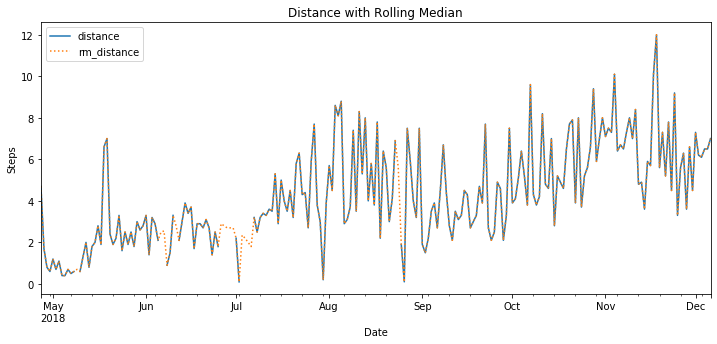

In [52]:
df['distance'].plot(figsize=(12,5))
df['rm_distance'].plot(style=':')

plt.title('Distance with Rolling Median')
plt.ylabel('Steps')
plt.legend()
plt.show()

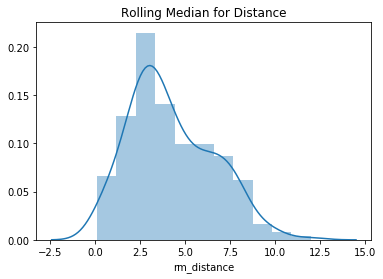

In [53]:
sns.distplot(df.rm_distance)

plt.title('Rolling Median for Distance')
plt.show()

## Calculate Rolling Mean

In [54]:
df = df.assign(steps_14_day_mean=df.steps.fillna(df.steps.rolling(14,min_periods=1,).mean()))

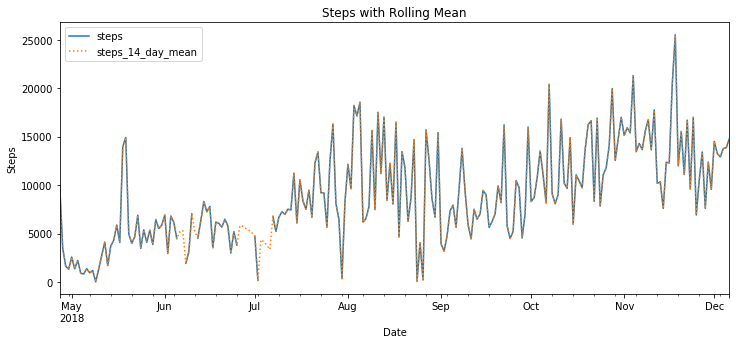

In [55]:
df['steps'].plot(figsize=(12,5))
df['steps_14_day_mean'].plot(style=':')

plt.title('Steps with Rolling Mean')
plt.ylabel('Steps')
plt.legend()
plt.show()

In [56]:
df['steps_14_day_mean'].isnull().sum()

0

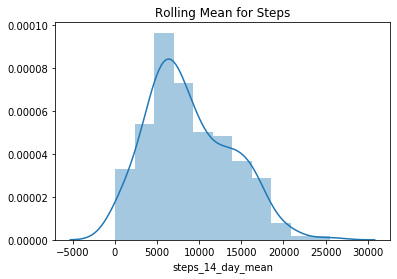

In [57]:
sns.distplot(df.steps_14_day_mean)

plt.title('Rolling Mean for Steps')
plt.show()

## Expanding Steps

In [58]:
df = df.assign(steps_14_day_expand=df.steps.fillna(df.steps.expanding(min_periods=14).mean()))

In [59]:
df['steps_14_day_expand'].isnull().sum()

0

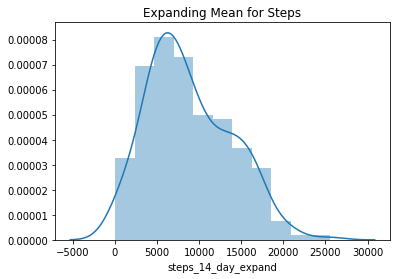

In [60]:
sns.distplot(df.steps_14_day_expand)

plt.title('Expanding Mean for Steps')
plt.show()

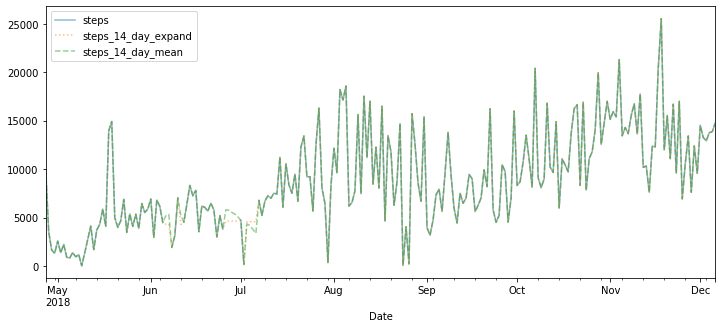

In [61]:
df[['steps', 'steps_14_day_expand', 'steps_14_day_mean']].plot(figsize=(12,5), style=['-', ':', '--'], alpha=.5)

plt.show()

### ETS Decomposition for Expand

- Error-Trend-Decomposition

- It looks like there is a lot of noise between August and September.

- It is easy to see the seasonality present.

- The trend is upward for the most part.

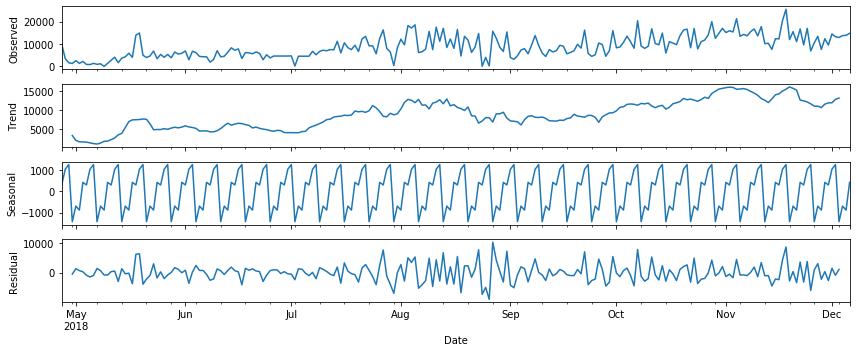

In [62]:
result = seasonal_decompose(df['steps_14_day_expand'], model='additive')

rcParams['figure.figsize']=(12,5)
result.plot()

plt.show()

## Exponentially Weighted Moving Average (EWMA)

- This allows the more recent data to be weighted more than the older data

- This might help reduce the noise in the data

- This could help us make better predictions and avoid problems with historical data issues.

In [63]:
df = df.assign(EWMA_14=df.steps.fillna(df.steps.expanding(min_periods=14).mean()))

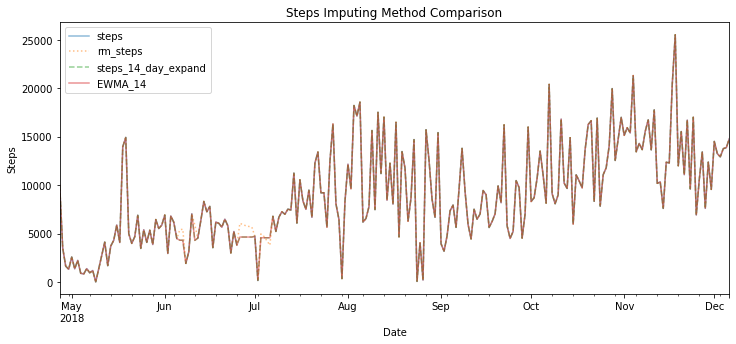

In [64]:
df[['steps', 'rm_steps', 'steps_14_day_expand', 'EWMA_14']].plot(figsize=(12,5), style=['-', ':', '--', '-'], alpha=.5)

plt.title('Steps Imputing Method Comparison')
plt.ylabel('Steps')
plt.show()

### ETS Decomposition for EWMA

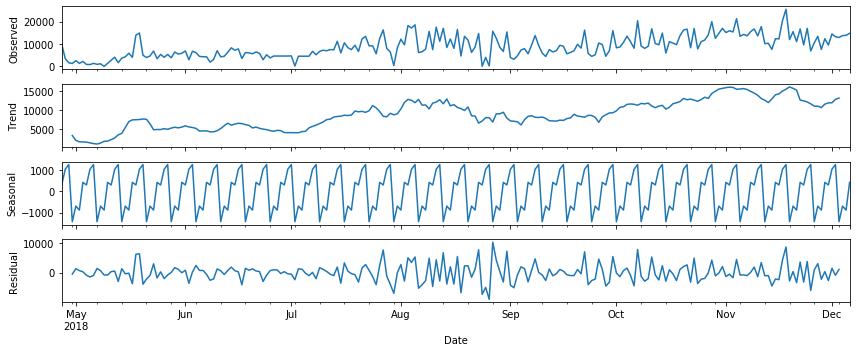

In [65]:
result = seasonal_decompose(df['EWMA_14'], model='additive')

rcParams['figure.figsize']=(12,5)
result.plot()

plt.show()

## Evaluate Impute Methods

- All of the methods we tried for imputing values where steps were missing performed close to the same. 

- We decided on the rm_steps, which is the rolling median of steps.

- We really thought that one method would decrease the noise or residuals more than the others, but it just didn't have here. There may have been too much time spent on this step for these findings.

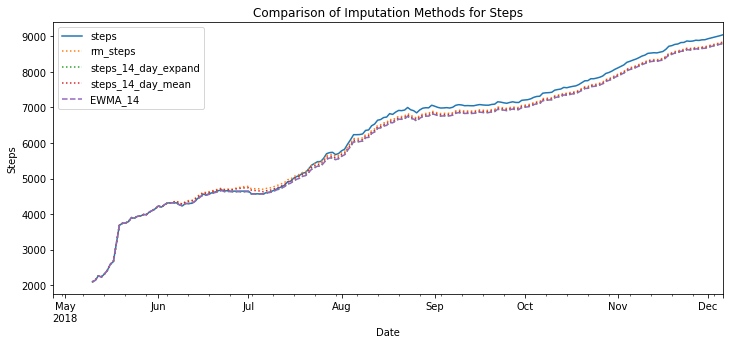

In [66]:
df[['steps', 'rm_steps', 'steps_14_day_expand', 'steps_14_day_mean', 'EWMA_14']].expanding(min_periods=14).mean().plot(style=['-', ':', ':', ':', '--'])

plt.ylabel('Steps')
plt.title('Comparison of Imputation Methods for Steps')
plt.show()

# Correlation with Steps

## Increase in Steps by Month

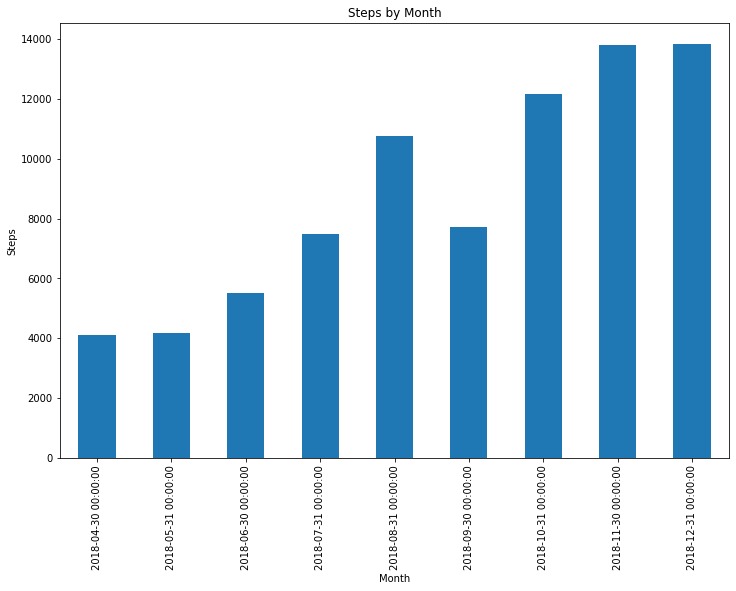

In [67]:
df['rm_steps'].resample('M').mean().plot.bar(figsize=(12,8))

plt.xlabel('Month')
plt.ylabel('Steps')
plt.title('Steps by Month')
plt.show()

## Steps and Calories Burned

- Sedentary mins looks negatively correlated with calories burned.

- Lightly active looks correlated with calories burned more than either very or fairly active.

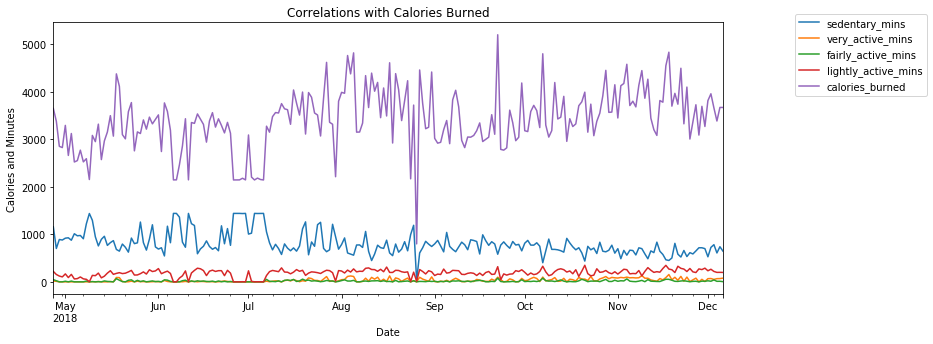

In [68]:
df[['sedentary_mins', 'very_active_mins', 'fairly_active_mins', 'lightly_active_mins', 'calories_burned']].plot()

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Correlations with Calories Burned')
plt.ylabel('Calories and Minutes')
plt.show()

In [69]:
df.isnull().sum()

calories_burned         0
steps                  12
distance               14
sedentary_mins          0
lightly_active_mins     0
fairly_active_mins      0
very_active_mins        0
activity_calories       0
active_total            0
stride                  0
rm_steps                0
rm_distance             0
steps_14_day_mean       0
steps_14_day_expand     0
EWMA_14                 0
dtype: int64

## Steps and Trend

- using Hodrick-Prescott filter to find the cycle and trend of steps

- here you can see where the actual steps are above or below the trend

In [70]:
steps_cycle, steps_trend = hpfilter(df['rm_steps'], lamb=600)

In [71]:
df['steps_trend'] = steps_trend

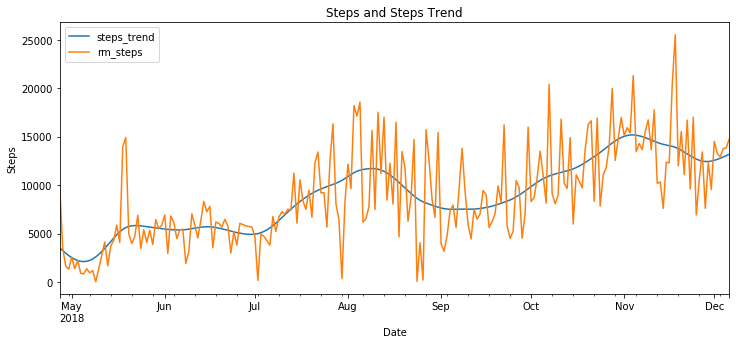

In [72]:
df[['steps_trend', 'rm_steps']].plot(figsize=(12,5))

plt.title('Steps and Steps Trend')
plt.ylabel('Steps')
plt.show()

## Percent Difference from First to Last Day

- There was a 48% increase in steps and distance from the first to the last day in the data set.

- There was a 358% increase in very_active_mins!

- There was a 77% increase in the ration_act_sed.

In [73]:
100 * (df.loc['2018-12-6'] - df.loc['2018-04-27'])/ df.loc['2018-04-27']

calories_burned          0.548095
steps                   48.169692
distance                48.936170
sedentary_mins         -44.127807
lightly_active_mins     -9.589041
fairly_active_mins     -91.304348
very_active_mins       358.823529
activity_calories       11.986301
active_total            -0.709220
stride                   0.517297
rm_steps                48.169692
rm_distance             48.936170
steps_14_day_mean       48.169692
steps_14_day_expand     48.169692
EWMA_14                 48.169692
steps_trend            275.013399
dtype: float64

### Correlation: Takeaways

- 

# Drop Remaining Columns

In [74]:
df.drop(columns=['lightly_active_mins', 'fairly_active_mins', 'very_active_mins', 'stride', 'steps_trend'], inplace=True)


# Split Train and Test

- We want our test set to be about 20% of of our data set or at least as large as the future prediction we would like to make.

- We want our test set to be at least 2 weeks, since we want to forecast 2 weeks into the future past 2018-12-06.

- train (210, 2)

- test (14, 2)

In [75]:
target_vars = ['rm_steps', 'calories_burned']
df = df.resample('D')[target_vars].sum()

In [76]:
train = df.loc[:'2018-11-22']
test = df.loc['2018-11-23':]

In [77]:
yhat = pd.DataFrame(test[target_vars])

In [78]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [79]:
yhat.head()

,rm_steps,calories_burned
Date,,
2018-11-23,16705,4494
2018-11-24,16705,4494
2018-11-25,16705,4494
2018-11-26,16705,4494
2018-11-27,16705,4494


In [80]:
train.shape

(210, 2)

In [81]:
test.shape

(14, 2)

In [82]:
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 224
Training Observations: 210
Testing Observations: 14


In [83]:
train.head(1), test.head(1)

(            rm_steps  calories_burned
 Date                                 
 2018-04-27    9971.0             3649,             rm_steps  calories_burned
 Date                                 
 2018-11-23    9602.0             3325)

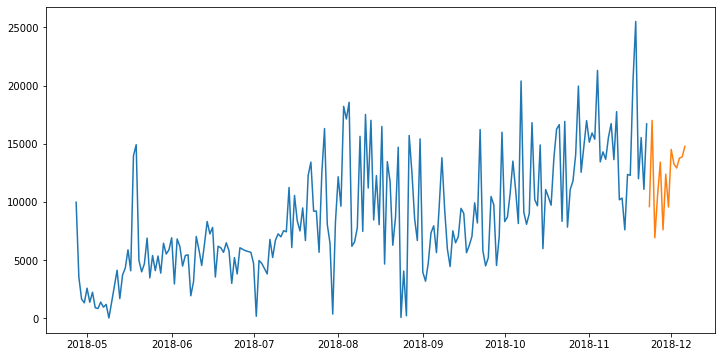

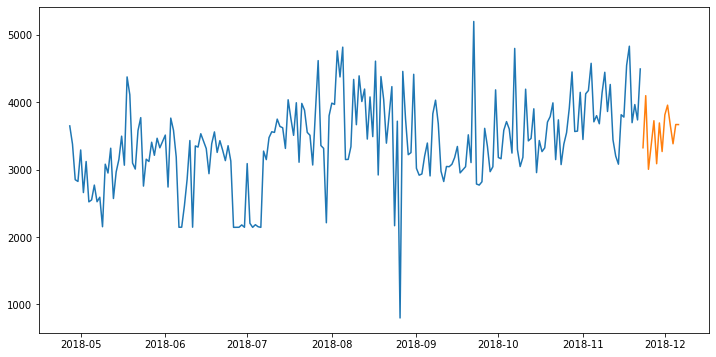

In [84]:
# validate train test split

for var in range(len(target_vars)):
    plt.figure(figsize=(12, 6))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    #plt.legend()
    plt.show()

# Model

## Basline: Last Observed Value

- Get a baseline model using this simple forecasting method.

- Predict all future values to be the last observed value.

In [85]:
def evaluate(target_var, train, test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [86]:
evaluate(target_var=target_vars, train=train, test=test, output=True)

MSE:  14739493.928571427
RMSE: 3839.2048562913947


In [87]:
def plot_and_eval(target_vars, train, test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

rm_steps -- MSE: 28495725.64 RMSE: 5338.14
calories_burned -- MSE: 983262.21 RMSE: 991.60


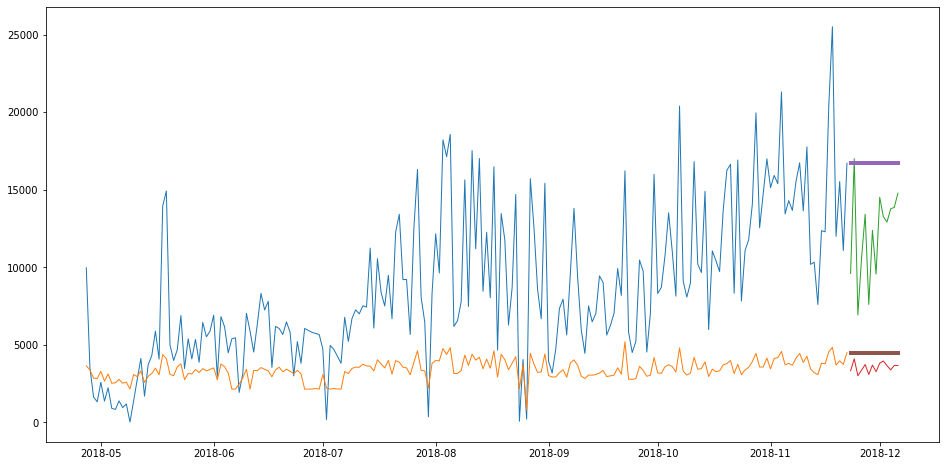

In [88]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

### Takeaways: Model

- 

# Forecast

# Final Takeaways

- Faith:


- Sean: